# Introduction

Rain is indispensable event in human life, especially in agriculture, or transportation. It affects greatly on various employment, such as farmers, who want to know exactly when it will rain to have the strategy for their farming activities. Or fishermans to plan for their fishing trips.

Therefore, in this project, we are going to build the predictive model that using the givien information, such as rain fall rate, or the temparature of a date, to forecast when the rain will happen. This job is extremely important since it would cause an adverse effect on people lives.

We will use data from Kaggle for this project. Let's briefly look at our dataset.


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_csv("D:\project\weatherAUS.csv")

In [3]:
print(df.shape)

(145460, 23)


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

This dataset contains about 10 years of daily weather observations from many locations across Australia. It includes information of 145460 days with 22 atmospheric features and one output feature.

All features are described below:
* **Date**: Date data taken.
* **Location**: City in Australia.
* **MinTemp**: Minimum temparature of that collected date.
* **MaxTemp**: Maxium temparature of that collected date.
* **Rainfall**: Amount of rainfall that day in mm.
* **Evaporation**: Amount of evaporation in mm for 24 hours.
* **Sunshine**: The number of hours the day is bright with sunlight.
* **WindGustDir**: Direction of highest wind speed during the 24 hours prior to 12 at night that day.
* **WindGustSpeed**: The highest wind speed in km/h during the 24 hours before 12 at night that day.
* **WindDir9am**: Wind direction at 9 am.
* **WindDir3pm**: Wind direction at 3 pm.

* **WindSpeed9am**: Wind speed at 9am in km/hour calculated from the average wind speed 10 minutes before 9 am.

* **WindSpeed3pm**: Wind speed at 3pm in km/hour calculated from the average wind speed 10 minutes before 3 pm.

* **Humidity9am**: Humidity at 9am in percentage.
* **Humidity3pm**: Humidity at 3pm in percentage.
* **Pressure9am**: Barometric pressure at 9am in hpa.
* **Pressure3pm**: Barometric pressure at 3pm in hpa.

* **Cloud9am**: Percentage of sky covered by clouds at 9am. counted in octas, units ⅛, counting how many units ⅛ of the sky is covered with clouds. If 0, the sky is clear, if 8, the sky is completely covered with clouds.
* **Cloud3pm**: Percentage of sky covered by clouds at 3 pm.

* **Temp9am**: Temparature at 9am in Celcius.
* **Temp3pm**: Temparature at 3pm in Celcius.

* **RainToday**: did it rain today: if the rainfall in the 24 hours before 9am exceeded 1mm, then this value is 1, otherwise it is 0.

* **RainTomorrow**: The output if it Rain or Not.


# Clean data
After understanding each feature of our dataset, the next thing before building the predictive model is to clean our dataset. Checking the missing value is the most important thing in this step.


In [7]:
df.isna().sum()

Date                 0
Location             0
MinTemp           1485
MaxTemp           1261
Rainfall          3261
Evaporation      62790
Sunshine         69835
WindGustDir      10326
WindGustSpeed    10263
WindDir9am       10566
WindDir3pm        4228
WindSpeed9am      1767
WindSpeed3pm      3062
Humidity9am       2654
Humidity3pm       4507
Pressure9am      15065
Pressure3pm      15028
Cloud9am         55888
Cloud3pm         59358
Temp9am           1767
Temp3pm           3609
RainToday         3261
RainTomorrow      3267
year                 0
month                0
dtype: int64

There are many missing values in dataset that we need to handle in order to enhance our classification models.

First, we will create the two new features, which is month and year for the later process

In [5]:
df["Date"]=pd.to_datetime(df['Date'])
df['year'],df['month']=df['Date'].dt.year.astype("category"),df["Date"].dt.month.astype("category")

In [8]:
num_col=df.select_dtypes(include='float64').columns.tolist()

First, I'll handle with NA values in numeric columns. We know that not every location at the specified month will have same temparature, or wind speed. Therefore, my idea is to convert NA values of each column by the median value of each location at the specified month

In [9]:
for i in num_col:
    a=df.groupby(['Location','month'])[i].median().fillna(0).reset_index()
    for j in df.Location.unique():
        for k in df.month.unique():
            df.loc[(df.Location==j)&(df.month==k),[i]]=df.loc[(df.Location==j)&(df.month==k),[i]].fillna(a.loc[(a.Location==j)&(a.month==k),i].item())
    
            


In [10]:
df.isnull().sum()

Date                 0
Location             0
MinTemp              0
MaxTemp              0
Rainfall             0
Evaporation          0
Sunshine             0
WindGustDir      10326
WindGustSpeed        0
WindDir9am       10566
WindDir3pm        4228
WindSpeed9am         0
WindSpeed3pm         0
Humidity9am          0
Humidity3pm          0
Pressure9am          0
Pressure3pm          0
Cloud9am             0
Cloud3pm             0
Temp9am              0
Temp3pm              0
RainToday         3261
RainTomorrow      3267
year                 0
month                0
dtype: int64

Similarly for categorical columns, I intend to fill the NA values with the most frequent categorical value based on their location and month.


In [11]:
list=['WindGustDir','WindDir9am',"WindDir3pm"]
for i in list:
    b=df.groupby(['Location','month',i])['Date'].count().reset_index()
    for j in df.Location.unique():
        for k in df.month.unique():
            df.loc[(df.Location==j)&(df.month==k),[i]]=df.loc[(df.Location==j)&(df.month==k),[i]].fillna(b.loc[(b.Location==j)&(b.month==k)].max()[i])
   

In [12]:
df.isnull().sum()

Date                0
Location            0
MinTemp             0
MaxTemp             0
Rainfall            0
Evaporation         0
Sunshine            0
WindGustDir         0
WindGustSpeed       0
WindDir9am          0
WindDir3pm          0
WindSpeed9am        0
WindSpeed3pm        0
Humidity9am         0
Humidity3pm         0
Pressure9am         0
Pressure3pm         0
Cloud9am            0
Cloud3pm            0
Temp9am             0
Temp3pm             0
RainToday        3261
RainTomorrow     3267
year                0
month               0
dtype: int64

Since RainTomorrow is our target column, so I will drop all the row containing NA values in RainTomorrow. Moreover, we also drop the missing values in RainToday since NA values only made up small percentage in the total.

In [13]:
df.drop(df[df.RainToday.isnull()].index,inplace=True)

df.drop(df[df.RainTomorrow.isnull()].index,inplace=True)



In [14]:
df.isnull().sum()

Date             0
Location         0
MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
RainTomorrow     0
year             0
month            0
dtype: int64

No     77.84
Yes    22.16
Name: RainTomorrow, dtype: float64


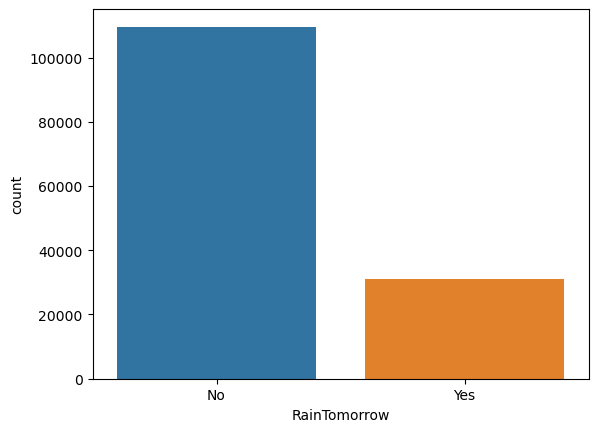

In [15]:
sns.countplot(df.RainTomorrow)

print(round(df.RainTomorrow.value_counts(normalize=True)*100,2))

The majority of our dataset is No Rain, while only 22.16% of data is having rain tomorrow. This perecentage is not small enough to be considered as imbalanced dataset. Therefore, I decide not to apply resample method for our data.

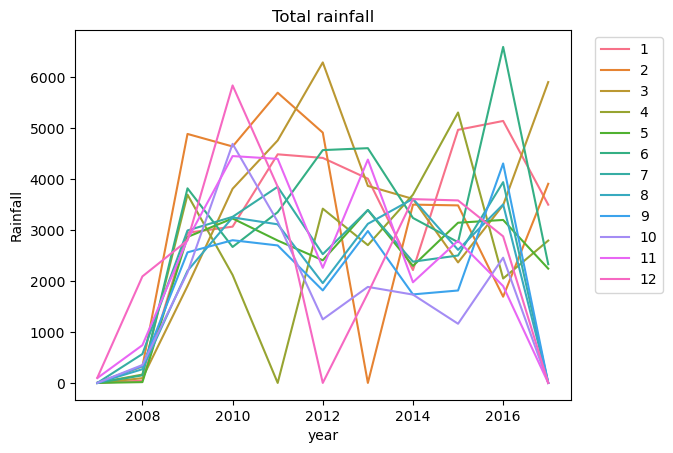

In [53]:
a=df.groupby(["year",'month'])['Rainfall'].sum().fillna(0).reset_index()
plt.figure()
seaborn_plot=sns.lineplot(data=a,x="year",y="Rainfall",hue='month')
seaborn_plot.legend (bbox_to_anchor = (1.2, 1))
plt.title("Total rainfall")
None

We see the total rain fall flucuated through months and years. There are some notice for this one:
* The rising of rain fall in March going fast from 2008 to 2012. However, there was a huge drop in the rainfall since then until it rose again in 2017.
* September and December can be the drought season since the total rainfall was very small, especially in September when there were no total rainfall surpassed 3000.
* There is a surprise in the trend of rainfall in February since from 2007 to 2012, the total rainfall was very high but it suddenly droppped sharply in 2013.

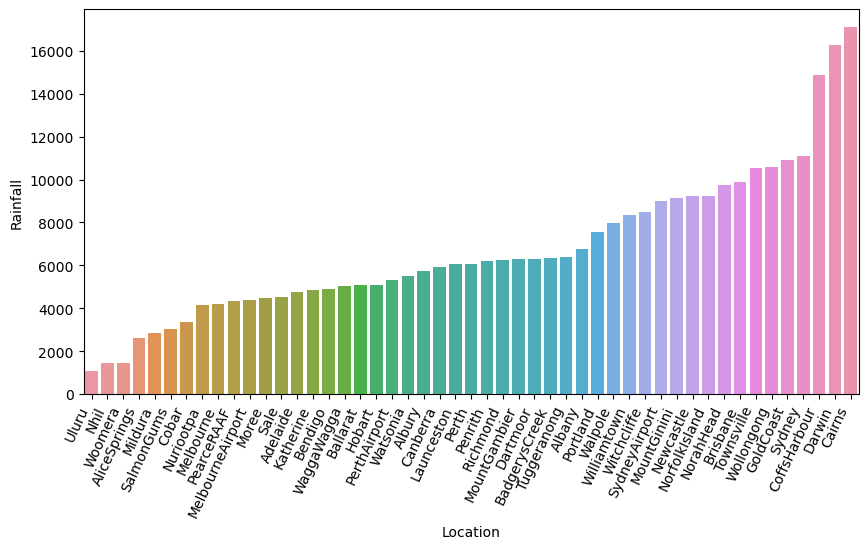

In [17]:
a=df.groupby(['Location'])['Rainfall'].sum().reset_index()
plt.figure(figsize=(10,5))
chart=sns.barplot(data=a,
            x="Location",
            y="Rainfall",
           order=a.sort_values("Rainfall").Location)
chart.set_xticklabels(
    chart.get_xticklabels(), 
    rotation=65, 
    horizontalalignment='right',
    fontweight='light'
    
)
plt.show()

* Uluru is the droughest area, when the rainfall rate is below 10000 in the last 10 years, followed by Nhil and Woomera. These places can be the desert areas.
* The majority cities in Australia only has the rainfall rate below 6000.

* CoffsHarbour, Darwin and Cairns are three cities that has the total rain surpass every area of Australia.

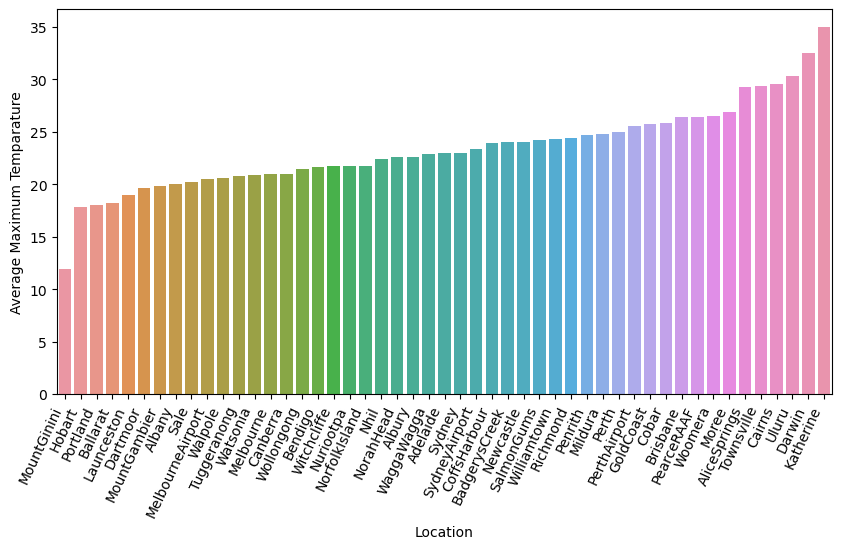

In [18]:
a=df.groupby(['Location'])['MaxTemp'].mean().fillna(0).reset_index()
plt.figure(figsize=(10,5))
chart=sns.barplot(data=a,
                 x='Location',
                 y='MaxTemp',
                 order=a.sort_values('MaxTemp').Location)
chart.set_xticklabels(
    chart.get_xticklabels(), 
    rotation=65, 
    horizontalalignment='right',
    fontweight='light'
    
)
plt.ylabel("Average Maximum Temparature")
None#don't show the label objects


From the plot, the average temparature of Australia is around 22 Celcius, which is very cool
* Uluru is one of the coldest area in Australia but it has the least rainfall in Australia
* While Cairns and Darwin are also cities with highest temparature in Australia and they also have the high rainfall rate.


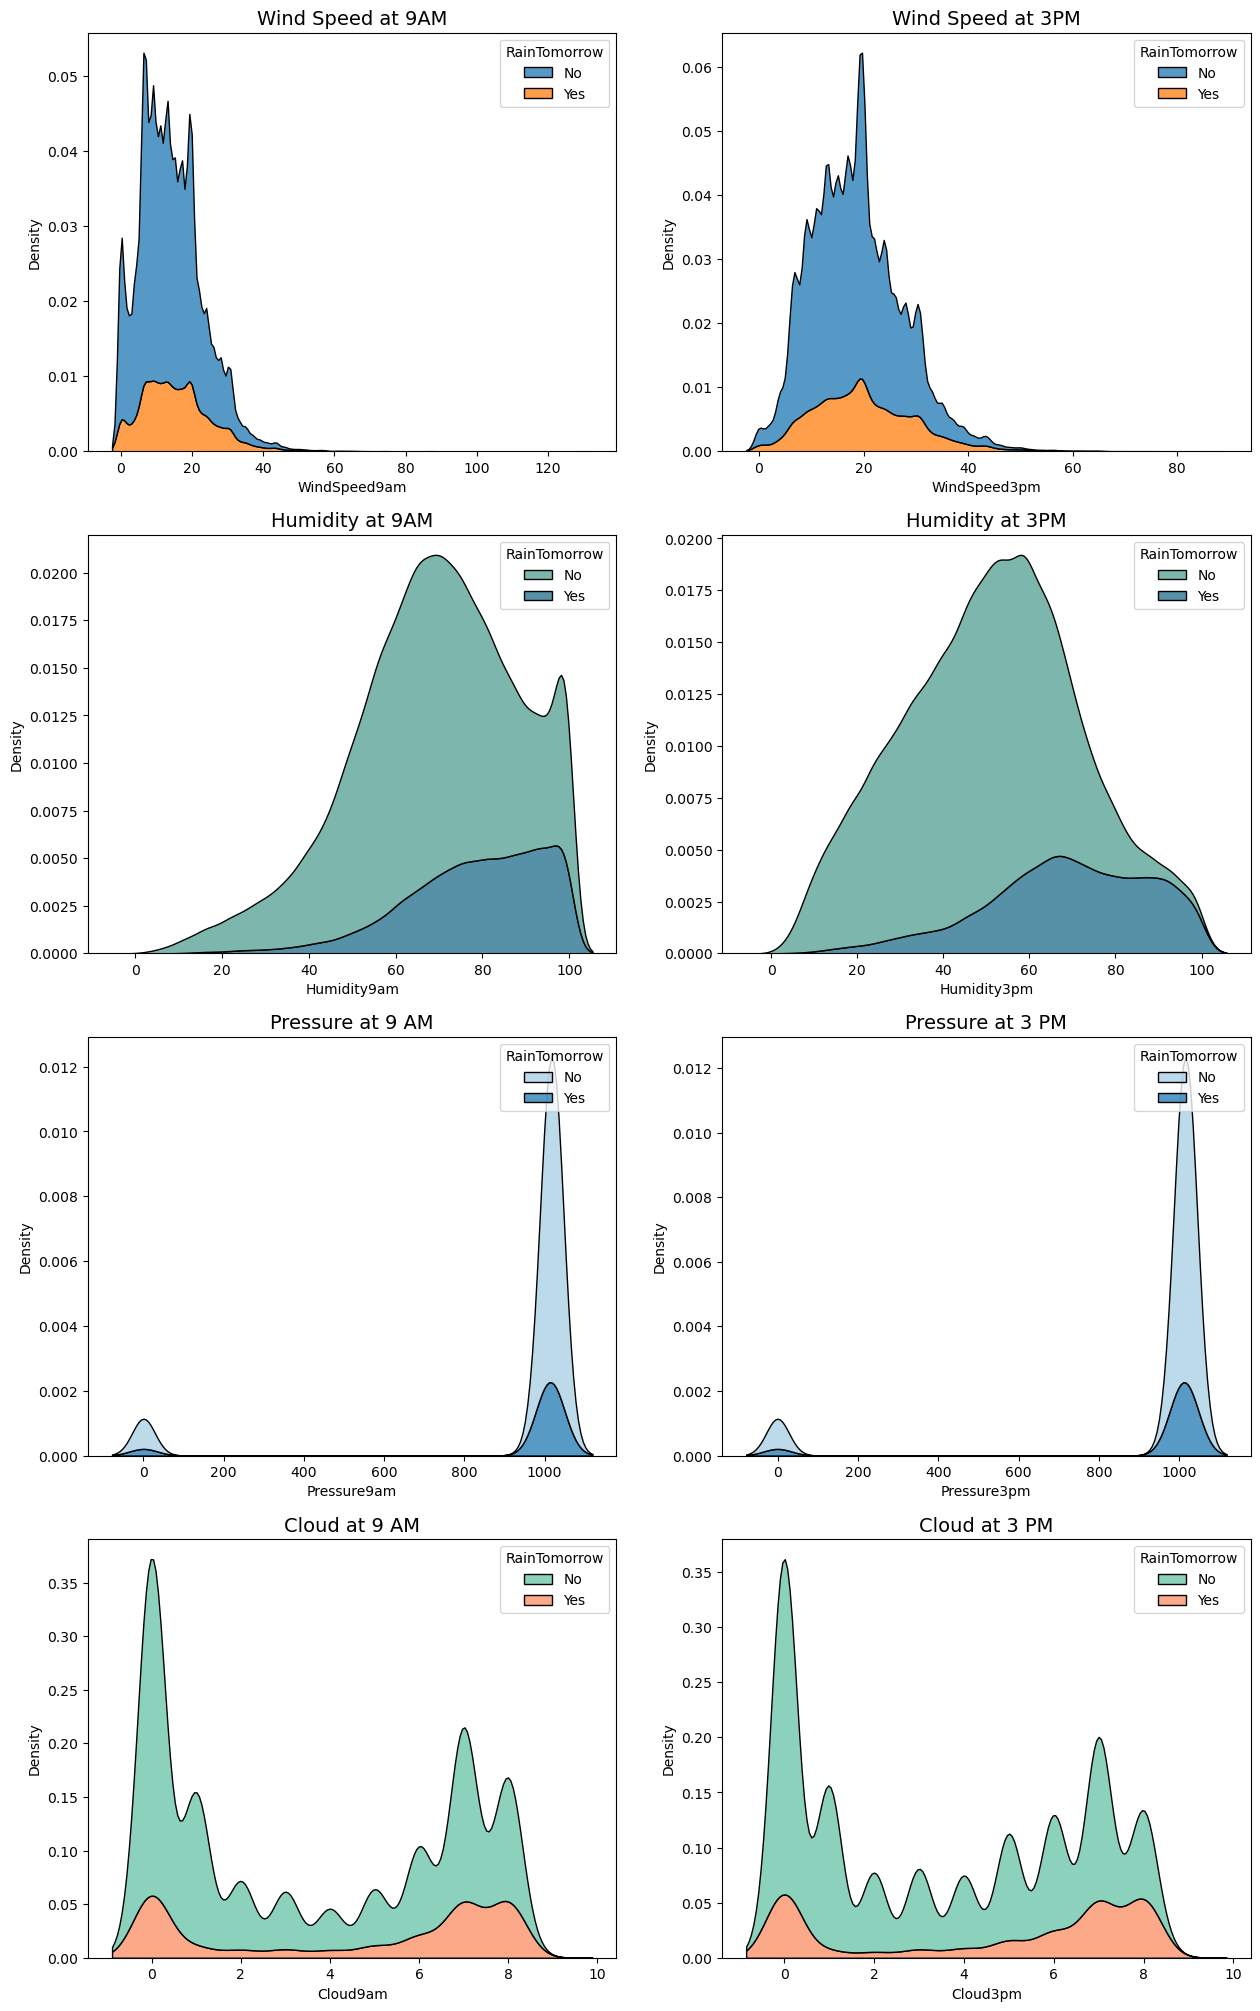

In [19]:
fig,ax=plt.subplots(4,2,figsize=(15,25))
#Wind speed 9am
sns.kdeplot(x=df.WindSpeed9am,ax=ax[0,0],color="blue",shade=True,hue=df.RainTomorrow,multiple="stack")
ax[0,0].set_title("Wind Speed at 9AM",fontsize=14)
#Wind speed 3pm
sns.kdeplot(x=df.WindSpeed3pm,ax=ax[0,1],color="blue",shade=True,hue=df.RainTomorrow,multiple="stack")
ax[0,1].set_title("Wind Speed at 3PM",fontsize=14)

#Humidity at 9am
sns.kdeplot(x=df.Humidity9am,ax=ax[1,0],palette="crest",shade=True,hue=df.RainTomorrow,multiple="stack")
ax[1,0].set_title("Humidity at 9AM",fontsize=14)
#Humidity at 3pm
sns.kdeplot(x=df.Humidity3pm,ax=ax[1,1],palette="crest",shade=True,hue=df.RainTomorrow,multiple="stack")
ax[1,1].set_title("Humidity at 3PM",fontsize=14)

#Pressure at 9am
sns.kdeplot(x=df.Pressure9am,ax=ax[2,0],palette="Paired",shade=True,hue=df.RainTomorrow,multiple="stack")
ax[2,0].set_title("Pressure at 9 AM",fontsize=14)

#Pressure at 3PM
sns.kdeplot(x=df.Pressure3pm,ax=ax[2,1],palette="Paired",shade=True,hue=df.RainTomorrow,multiple="stack")
ax[2,1].set_title("Pressure at 3 PM",fontsize=14)

#Humidity at 9am
sns.kdeplot(x=df.Cloud9am,ax=ax[3,0],palette="Set2",shade=True,hue=df.RainTomorrow,multiple="stack")
ax[3,0].set_title("Cloud at 9 AM",fontsize=14)

#Humidity at 3PM
sns.kdeplot(x=df.Cloud3pm,ax=ax[3,1],palette="Set2",shade=True,hue=df.RainTomorrow,multiple="stack")
ax[3,1].set_title("Cloud at 3 PM",fontsize=14)
None

From the plot, we see that there is no huge difference between the Wind Speed, Humidity, Pressure and cloud between 9AM and 3PM.

* On rainy day, the wind speed usually between 10 to 21 km/h at 9AM and not changing much at 3PM
* The humidity at 3PM on rainy day are right-skewed than on its on the non-rainy days.



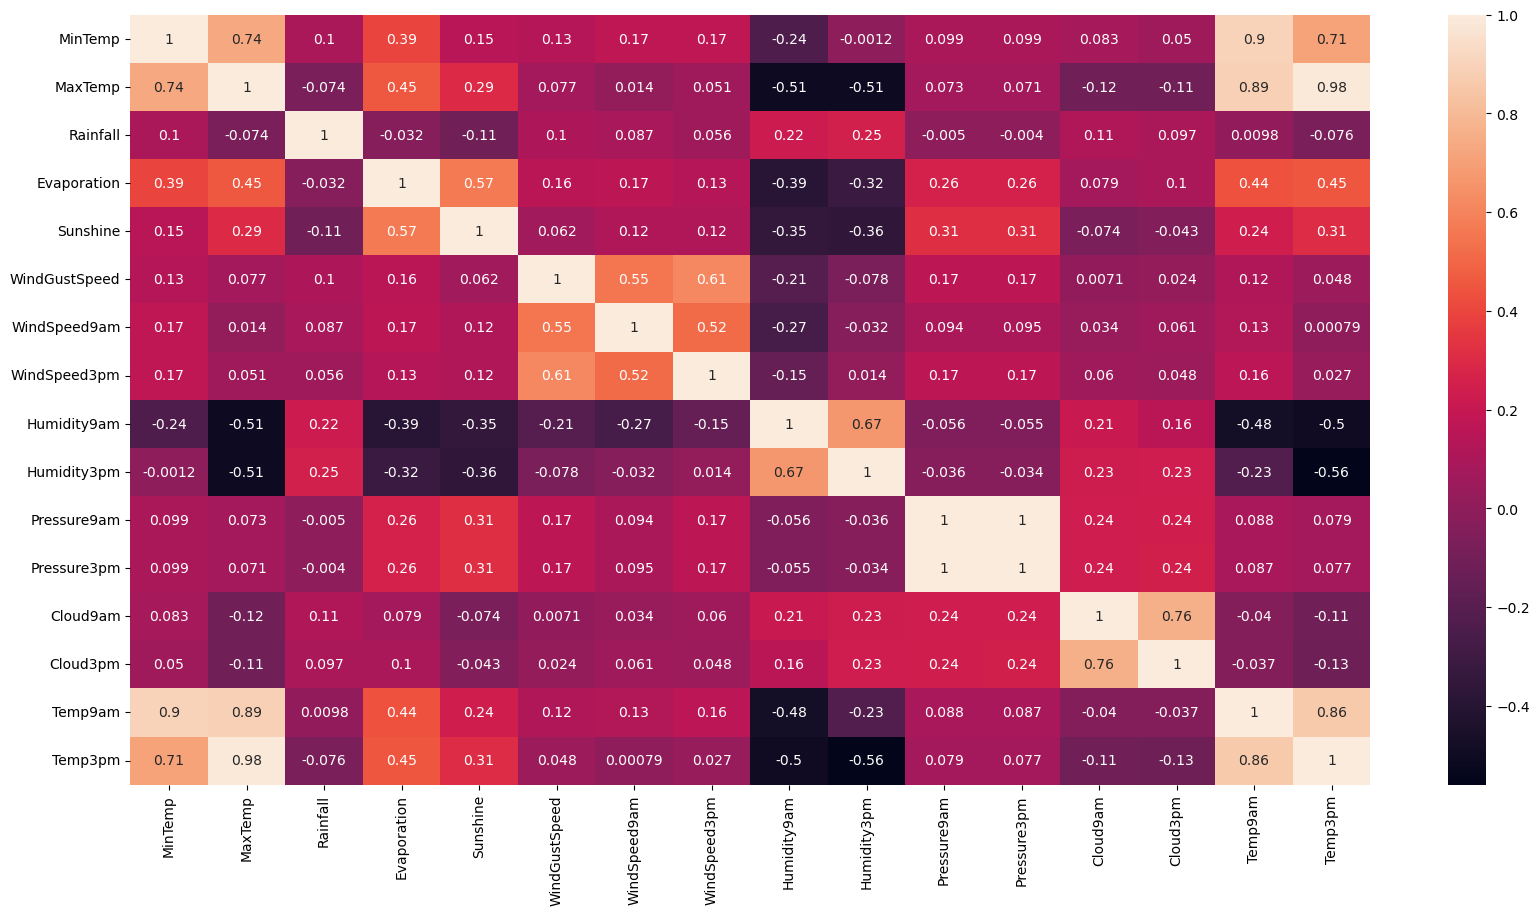

In [20]:
plt.figure(figsize = (20,10))
sns.heatmap(df.corr(), annot = True)
None

It is not supprising that the each feature at 9am and 3pm has the high correlation. For example, there is a strong positive correlation between cloud at 9am and cloud at 3pm. We can see that there is the strong positive relationship between the temparature and evaporation
# Feature engineering
In next section, we remove the outliers and  add some new features, dummy variables for the categorical column and choose the features for our classification models.

In [21]:
df.RainTomorrow=np.where(df.RainTomorrow=="No",0,1)


We know that outliers can distort badly on our dataset, then it can casue the bad prediction later. In this project, I will use the statistical technique of IQR to eliminate points that lower than Q1-1.5*IQR and Q3+1.5*IQR 

In [22]:
#Remove outliers
Q1 = df[num_col].quantile(0.25)
Q3 =df[num_col].quantile(0.75)
IQR = Q3 - Q1
df_no_outliers = df[~((df[num_col] < (Q1 - 1.5 * IQR)) | (df[num_col] > (Q3 + 1.5 * IQR))).any(axis=1)]
df_no_outliers 

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,year,month
0,2008-12-01,Albury,13.4,22.9,0.6,0.0,0.0,W,44.0,W,...,1007.7,1007.1,8.0,5.0,16.9,21.8,No,0,2008,12
1,2008-12-02,Albury,7.4,25.1,0.0,0.0,0.0,WNW,44.0,NNW,...,1010.6,1007.8,7.0,5.0,17.2,24.3,No,0,2008,12
2,2008-12-03,Albury,12.9,25.7,0.0,0.0,0.0,WSW,46.0,W,...,1007.6,1008.7,7.0,2.0,21.0,23.2,No,0,2008,12
3,2008-12-04,Albury,9.2,28.0,0.0,0.0,0.0,NE,24.0,SE,...,1017.6,1012.8,7.0,5.0,18.1,26.5,No,0,2008,12
4,2008-12-05,Albury,17.5,32.3,1.0,0.0,0.0,W,41.0,ENE,...,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0,2008,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145454,2017-06-20,Uluru,3.5,21.8,0.0,0.0,0.0,E,31.0,ESE,...,1024.7,1021.2,6.0,3.5,9.4,20.9,No,0,2017,6
145455,2017-06-21,Uluru,2.8,23.4,0.0,0.0,0.0,E,31.0,SE,...,1024.6,1020.3,6.0,3.5,10.1,22.4,No,0,2017,6
145456,2017-06-22,Uluru,3.6,25.3,0.0,0.0,0.0,NNW,22.0,SE,...,1023.5,1019.1,6.0,3.5,10.9,24.5,No,0,2017,6
145457,2017-06-23,Uluru,5.4,26.9,0.0,0.0,0.0,N,37.0,SE,...,1021.0,1016.8,6.0,3.5,12.5,26.1,No,0,2017,6


Moreover, I'll add some new features to check if these new features have any relation with our target variables or not. I will create the features of difference of Temparature, Humidity and Pressure between 9AM and 3PM. Since sometimes the sudden changes of the atmospheric features in the day can be related to the suddend raining.

And then, I also find hte average wind speed of rainy and non-rainy days to check the relations with the response variable.

In [23]:
df_no_outliers['RT_WGS3PM_mean'] = df_no_outliers.groupby('RainTomorrow')[ 'WindSpeed3pm'].transform('mean')
df_no_outliers['Temp_Diff'] = df_no_outliers['MaxTemp'] -df_no_outliers['MinTemp']
df_no_outliers['Humidity_Diff'] = df_no_outliers['Humidity9am'] - df_no_outliers['Humidity3pm']
df_no_outliers['Pressure_Diff'] = df_no_outliers['Pressure9am'] - df_no_outliers['Pressure3pm']
df_no_outliers['Tem9am_Team3pm_Diff'] = df_no_outliers['Temp9am'] - df_no_outliers['Temp3pm']
df_no_outliers['RT_WGS_mean'] = df_no_outliers.groupby('RainTomorrow')['WindGustSpeed'].transform('mean')
df_no_outliers['RT_WS9AM_mean'] = df_no_outliers.groupby('RainTomorrow')['WindSpeed9am'].transform('mean')

In [24]:
corr_matrix=df_no_outliers.corr()
corr_matrix=abs(corr_matrix['RainTomorrow'])
print(corr_matrix)

MinTemp                0.068506
MaxTemp                0.112947
Rainfall               0.162161
Evaporation            0.065740
Sunshine               0.177023
WindGustSpeed          0.164830
WindSpeed9am           0.042040
WindSpeed3pm           0.046832
Humidity9am            0.164051
Humidity3pm            0.367280
Pressure9am            0.191592
Pressure3pm            0.187256
Cloud9am               0.130363
Cloud3pm               0.175357
Temp9am                0.002417
Temp3pm                0.147121
RainTomorrow           1.000000
RT_WGS3PM_mean         1.000000
Temp_Diff              0.253788
Humidity_Diff          0.254289
Pressure_Diff          0.014082
Tem9am_Team3pm_Diff    0.266885
RT_WGS_mean            1.000000
RT_WS9AM_mean          1.000000
Name: RainTomorrow, dtype: float64


What a surprise that our new features have moderate positive relation with the RainTomorrow features, especially the average value of Wind speed, with the correlation of 1. I will choose the feature for our models that has correlation with target column higher than 0.10. Moreover, I also drop the column WindDir9AM since the relationship between WindDir at 9am and 3pm is very strong and it can casue the multicollinearity problem in prediction. 

In [26]:
df_no_outliers.drop(['Date','MinTemp','Evaporation','WindSpeed9am','WindSpeed3pm','Temp9am','Pressure_Diff','WindDir9am'],axis=1,inplace=True)

In [27]:
df_no_outliers=pd.get_dummies(data=df_no_outliers,columns=['Location',
 'WindGustDir',
 'WindDir3pm',
 'RainToday'],drop_first=True)

In [28]:
df_no_outliers.head(2)

,MaxTemp,Rainfall,Sunshine,WindGustSpeed,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,...,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,RainToday_Yes
0,22.9,0.6,0.0,44.0,71.0,22.0,1007.7,1007.1,8.0,5.0,...,0,0,0,0,0,0,0,1,0,0
1,25.1,0.0,0.0,44.0,44.0,25.0,1010.6,1007.8,7.0,5.0,...,0,0,0,0,0,0,0,0,1,0


In [29]:
y=df_no_outliers.RainTomorrow
X=df_no_outliers.drop("RainTomorrow",axis=1)
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=42)

In [30]:
from sklearn.preprocessing import StandardScaler
scale=StandardScaler()
X_train_scaled=scale.fit_transform(X_train)
X_test_scaled=scale.fit_transform(X_test)

In [31]:
#Machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import ConfusionMatrixDisplay, classification_report,confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

The accuracy of Logistic Regression on 5-Fold test is [1. 1. 1. 1. 1.]
The accuracy of logistic regression on test set is:  1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20426
           1       1.00      1.00      1.00      3790

    accuracy                           1.00     24216
   macro avg       1.00      1.00      1.00     24216
weighted avg       1.00      1.00      1.00     24216



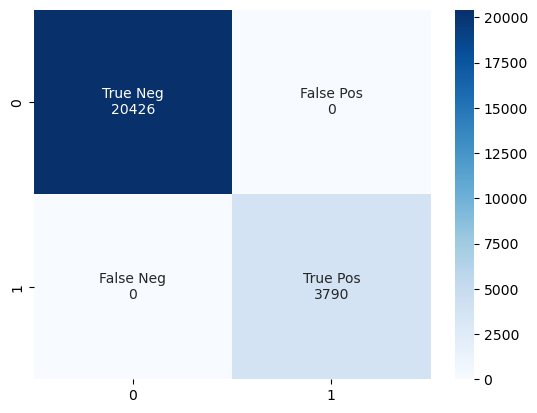

In [40]:
lr=LogisticRegression(max_iter=500)
cv=cross_val_score(lr,X_train_scaled,y_train,cv=5,scoring='accuracy')
print("The accuracy of Logistic Regression on 5-Fold test is",cv)
lr=LogisticRegression(max_iter=500).fit(X_train_scaled,y_train)
predict_value=lr.predict(X_test_scaled)
print("The accuracy of logistic regression on test set is: ",accuracy_score(predict_value,y_test))

print(classification_report(predict_value,y_test))


#Confusion matrix
cf_matrix=confusion_matrix(y_test,predict_value)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]

labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
None

The result of Logistic Regression is amazaing, withe the 100% accurcay.

In [41]:
#Decision tree 
dt=DecisionTreeClassifier()
param={'criterion':['gini','entropy','log_loss'],
      'max_depth':[5,10,12],
      'max_features':['sqrt','log2']}
rand=RandomizedSearchCV(dt,param,cv=5,scoring="accuracy",n_iter=10).fit(X_train_scaled,y_train)

#Find the best parameter
rand.best_params_


{'max_features': 'sqrt', 'max_depth': 12, 'criterion': 'entropy'}

The accuracy of Decision Tree on 5-fold test is: [1.         0.99807295 1.         0.99518205 0.99944938]
The accuracy of Decision Tree on test set is:  0.9839775355137099
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     20668
           1       0.92      0.98      0.95      3548

    accuracy                           0.98     24216
   macro avg       0.96      0.98      0.97     24216
weighted avg       0.98      0.98      0.98     24216



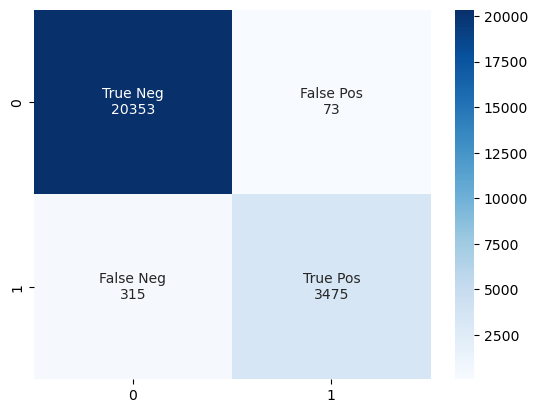

In [43]:
#Decision tree with the optimal paraeter
dt=DecisionTreeClassifier(criterion="entropy",max_features="sqrt",max_depth=12)
cv=cross_val_score(dt,X_train_scaled,y_train,cv=5)
print("The accuracy of Decision Tree on 5-fold test is:", cv)

dt.fit(X_train_scaled,y_train)
predict_value=dt.predict(X_test_scaled)

print("The accuracy of Decision Tree on test set is: ", accuracy_score(y_test,predict_value))

#report
print(classification_report(predict_value,y_test))

#Confusion matrix
cf_matrix=confusion_matrix(y_test,predict_value)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]

labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
None

Decision Tree did not work as well as Logistic Regression, especially on predicting no raining. The recall is only about 0.92.

In [47]:
#Random Forest
rf=RandomForestClassifier()
param={'max_features':['auto','sqrt'],
      'max_depth':[5,10,12,15],
      'n_estimators':[50,100,150,200]}
rand=RandomizedSearchCV(rf,param,cv=5,scoring="accuracy",n_iter=10).fit(X_train_scaled,y_train)
rand.best_params_

{'n_estimators': 200, 'max_features': 'auto', 'max_depth': 12}

The accuracy of Random Forest on 5-fold test is [1. 1. 1. 1. 1.]
The accuracy of RF on test set is: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20426
           1       1.00      1.00      1.00      3790

    accuracy                           1.00     24216
   macro avg       1.00      1.00      1.00     24216
weighted avg       1.00      1.00      1.00     24216



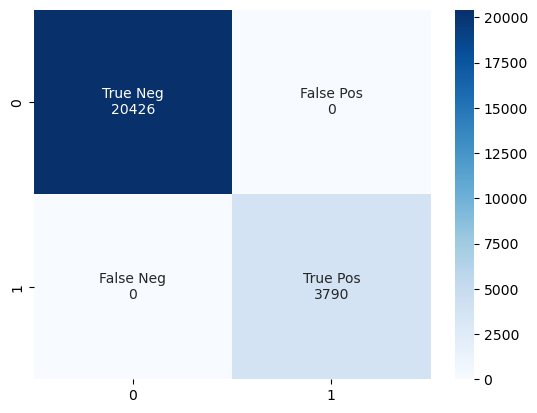

In [52]:
#Random forest with optimal parameters
rf=RandomForestClassifier(n_estimators=200,max_features='auto',max_depth=12)
cv=cross_val_score(rf,X_train_scaled,y_train,cv=5)
print("The accuracy of Random Forest on 5-fold test is",cv)
#Test accuracy
rf.fit(X_train_scaled,y_train)
predict_value=rf.predict(X_test_scaled)
print("The accuracy of RF on test set is:",accuracy_score(predict_value,y_test))

#report
print(classification_report(y_test,predict_value))

#Confusion matrix
cf_matrix=confusion_matrix(y_test,predict_value)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]

labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
None

Random Forest also predicts 100% raining or not raining

# Conclusion
We can see the accuracy of our classification models is extremely surprising, especially with Logistic regression and Random forest with the accruacy of 100%. This is the result of our feature selection process, and also the scaling step in our dataset